In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as ss
try:
    xrange
except NameError:
    xrange = range
    
def sample_gumbels(location, size=1):
    return -np.log(np.random.exponential(size=size)) + location

def softmax(x):
    c = np.max(x)
    return np.exp(x - c) / np.sum(np.exp(x - c))

In [2]:
class Bandit(object):
    def __init__(self, num_arms, variance_pattern='equal'):
        self.num_arms = num_arms
        self.means = np.linspace(-10, 10, num_arms)
        if variance_pattern == 'equal':
            self.stdevs = np.ones(num_arms)
        elif variance_pattern == 'decreasing':
            self.stdevs = np.linspace(15, 1, num_arms) ** 1.1
        elif variance_pattern == 'extreme':
            self.stdevs = np.linspace(15, 1, num_arms) ** 2.5
   
    def sample_rewards(self):
        return self.means + self.stdevs * np.random.randn(self.num_arms)
  
    def plot_arm_distributions(self):
        xs = np.linspace(-1 * self.num_arms, 1 * self.num_arms, 200)
        for mean, stdev in zip(self.means, self.stdevs):
            plt.plot(xs, ss.norm.pdf(xs, mean, stdev))

Text(0.5, 1.0, 'extreme')

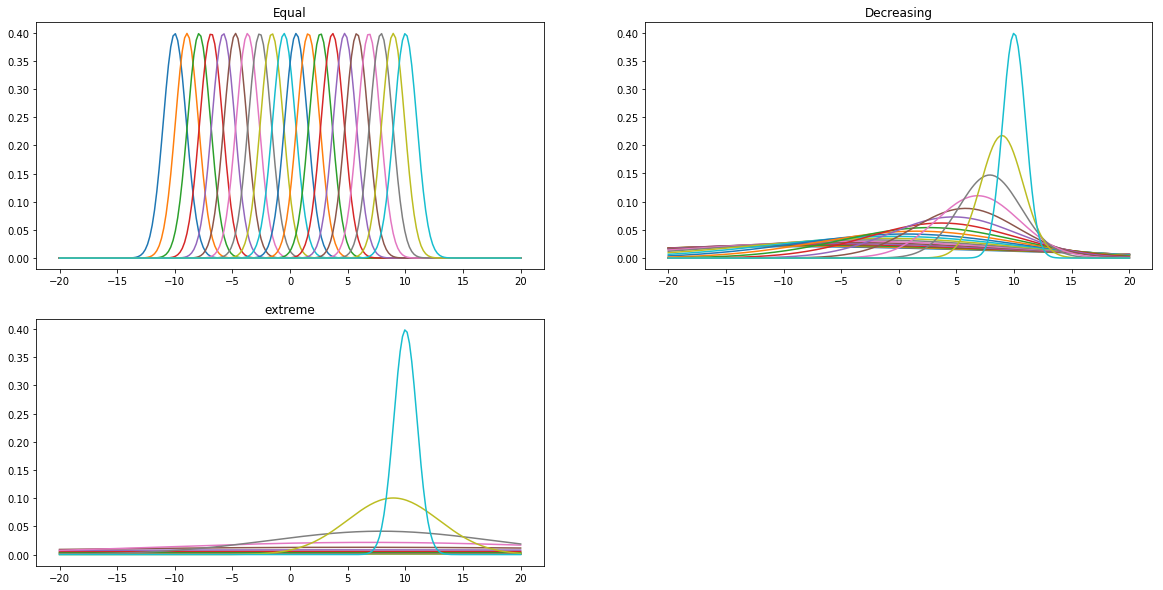

In [3]:
num_arms = 20
b_eq = Bandit(num_arms, variance_pattern='equal')
b_decreasing = Bandit(num_arms, variance_pattern='decreasing')
b_extreme = Bandit(num_arms, variance_pattern='extreme')

plt.figure(figsize=(20, 10))
plt.subplot(2, 2,1)
b_eq.plot_arm_distributions()
plt.title('Equal')
plt.subplot(2, 2, 2)
b_decreasing.plot_arm_distributions()
plt.title('Decreasing')
plt.subplot(2, 2, 3)
b_extreme.plot_arm_distributions()
plt.title('extreme')

In [4]:
class Model(object):
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.logits = .1 * np.random.randn(num_actions)
    
    def sample_gumbels(self):
        return self.logits + sample_gumbels(0, size=self.num_actions)
  
    def sample_action(self):
        return np.argmax(self.sample_gumbels())
  
    def sample_and_improvement(self, bandit, epsilon=None, share_noise=True, num_search_step_limit=None):
        """Draw a sample and an improvement."""
        g = self.sample_gumbels()
        sample = np.argmax(g)
        rewards = bandit.sample_rewards()

        if epsilon is not None and share_noise:
            direct_objectives = g + epsilon * rewards
        elif epsilon is not None and not share_noise:
            direct_objectives = self.sample_gumbels() + epsilon * rewards
        else:
            direct_objectives = rewards

        if num_search_step_limit is None:
            improvement = np.argmax(direct_objectives)

        else:
            # candidate_indices = np.random.permutation(self.num_actions)[:num_search_step_limit]
            candidate_indices = np.argsort(g)[:num_search_step_limit]
            best_candidate_index = np.argmax(direct_objectives[candidate_indices])
            improvement = candidate_indices[best_candidate_index]
            if direct_objectives[improvement] < direct_objectives[sample]:
                improvement = sample

        return sample, improvement, rewards[sample]
  
    def apply_unnormalized_update(self, positive_index, negative_index, learning_rate=.1):
        self.logits[positive_index] += learning_rate
        self.logits[negative_index] -= learning_rate
    
    def apply_softmax_update(self, positive_index, learning_rate=.1):
        self.logits[positive_index] += learning_rate
        self.logits -= learning_rate * softmax(self.logits)

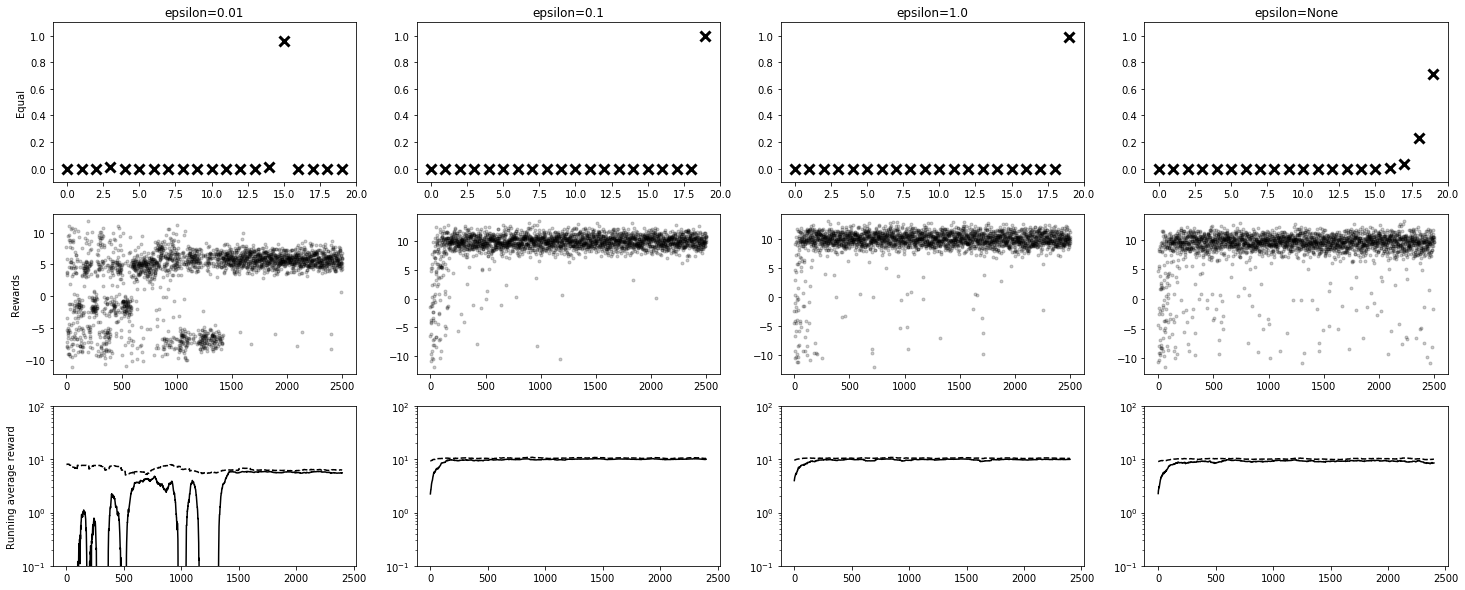

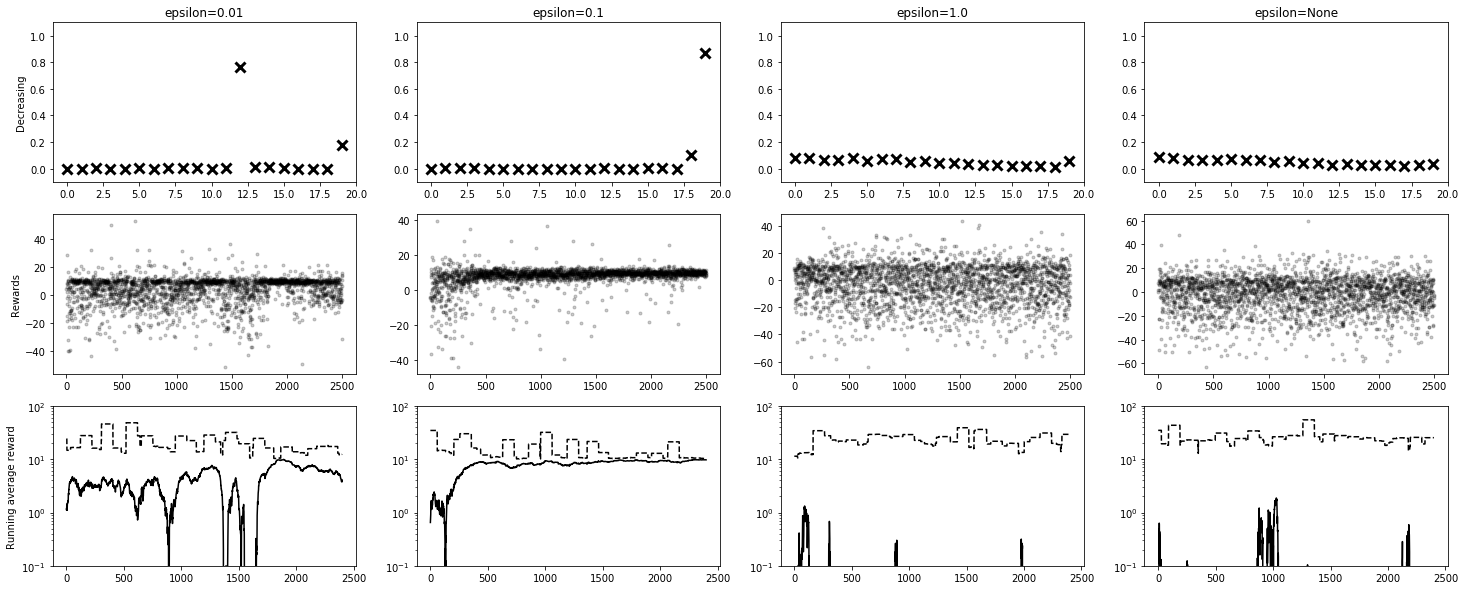

In [5]:
final_logits = {}
epsilons = [.01, .1, 1.0, None]
for variance_pattern, b in [('Equal', b_eq), ('Decreasing', b_decreasing)]:
    plt.figure(figsize=(25, 10))
    for i, epsilon in enumerate(epsilons):
        m = Model(num_arms)
        rewards = []
        for t in xrange(2500):
            sample, improvement, reward = m.sample_and_improvement(b, epsilon=epsilon, num_search_step_limit=None)
      
            # TODO: make sure the optimization works.
            if epsilon is None:
                learning_rate = 100.0 / (1000.0 + t)
            else:
                learning_rate = 100.0 / (1000.0 + t) * 1.0 / np.sqrt(epsilon)
            # m.apply_unnormalized_update(improvement, sample, learning_rate=learning_rate)
            m.apply_softmax_update(improvement, learning_rate=learning_rate)
            rewards.append(reward)
        rewards = np.array(rewards)

        plt.subplot(3, 4, i + 1)
        if i == 0:
            plt.ylabel(variance_pattern)
        plt.plot(softmax(m.logits), 'kx', ms=10, mew=3)
        plt.title('epsilon={}'.format(epsilon))
        plt.ylim([-.1, 1.1])
        plt.xlim([-1, 20])

        plt.subplot(3, 4, 4 + i + 1)
        if i == 0:
            plt.ylabel('Rewards')
        plt.plot(rewards, 'k.', alpha=.2, mew=1)

        plt.subplot(3, 4, 8 + i + 1)
        window_size = 100
        if i == 0:
            plt.ylabel('Running average reward')
        plt.semilogy(np.convolve(rewards, np.ones((window_size,)) / window_size, mode='valid'), 'k-')

        eval_eps = 1.0
        exp_rewards = np.exp(eval_eps * rewards)
        avg_exp_rewards = np.convolve(exp_rewards, np.ones((window_size,)) / window_size, mode='valid')
        plt.semilogy(np.log(avg_exp_rewards) - np.log(eval_eps), 'k--')
        plt.ylim([.1, 100])

    

# Variance reduction?

In [6]:
def controlled_gradient(improvement, sample, model_probs):
    result = np.zeros_like(model_probs)
    result[improvement] += 1
    result[sample] -= 1
    return result

def rao_blackwell_gradient(improvement, unused_sample, model_probs):
    result = np.zeros_like(model_probs)
    result[improvement] += 1
    result -= model_probs
    return result

In [7]:
num_arms = 100
epsilon = .1
m = Model(num_arms)
b = Bandit(num_arms, variance_pattern='equal')

In [8]:
inv_temps = [0, .01, .1, .2, .5, 1.0, 5., 10., 20]
gs = []
cs = []
rs = []

for inv_temp in inv_temps:
    gradients = []
    controlled_gradients = []
    rao_blackwell_gradients = []
    m.logits = inv_temp * b.means
    for _ in xrange(1000):
        m_probs = softmax(m.logits)

        sample, improvement, reward = m.sample_and_improvement(b, epsilon=epsilon, share_noise=False)
        gradients.append(controlled_gradient(improvement, sample, m_probs))

        sample, improvement, reward = m.sample_and_improvement(b, epsilon=epsilon)
        controlled_gradients.append(controlled_gradient(improvement, sample, m_probs))
        rao_blackwell_gradients.append(rao_blackwell_gradient(improvement, sample, m_probs))

    gs.append(np.vstack(gradients))
    cs.append(np.vstack(controlled_gradients))
    rs.append(np.vstack(rao_blackwell_gradients))
                              

(0.01, 20)

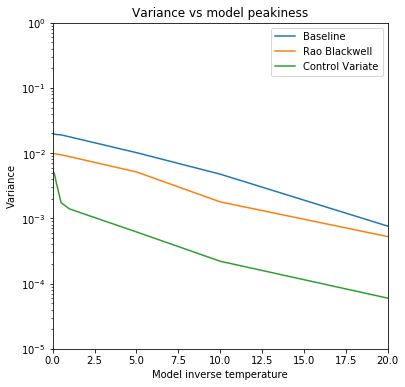

In [9]:
plt.figure(figsize=(6, 6))
plt.semilogy(inv_temps, [np.mean(np.var(g, axis=0)) for g in gs], label='Baseline')
plt.semilogy(inv_temps, [np.mean(np.var(r, axis=0)) for r in rs], label='Rao Blackwell')
plt.semilogy(inv_temps, [np.mean(np.var(c, axis=0)) for c in cs], label='Control Variate')
plt.legend()
plt.title('Variance vs model peakiness')
plt.xlabel('Model inverse temperature')
plt.ylabel('Variance')
plt.ylim([.00001, 1])
plt.xlim([.01, 20])